# Load Data

O Free Spoken Digit Dataset é uma coleção de gravações de áudio de declarações de dígitos (“zero” a “nove”) de diferentes pessoas.
O objetivo desta competição é identificar corretamente o dígito que está sendo pronunciado em cada gravação. 

In [71]:
from src.audioProcessor import AudioProcessor

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from os import listdir
from os.path import join
from scipy.io import wavfile

import IPython.display as ipd


In [72]:
audio = AudioProcessor()
X = []
y = []
for audio_file in audio.audio_files:
   # X.append(audio_file.sample)
    y.append(int(audio_file.label))

files = 'data/recordings/'
ds_files = listdir(files)

for file in ds_files:
    label = int(file.split("_")[0])
    rate, data = wavfile.read(join(files, file))

    X.append(data.astype(np.float32))

len(X), len(y)

INFO:src.audioProcessor:Found 3000 audio files in data/recordings


(3000, 3000)

In [73]:
np.unique(y, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([300, 300, 300, 300, 300, 300, 300, 300, 300, 300]))





O problema está bem equilibrado: para cada uma das classes temos 300 amostras no conjunto de dados.
Todas as gravações são amostradas na taxa de 8 kHZ

Os sinais de áudio têm comprimentos diferentes.
Alguns deles têm intervalos iniciais e de silêncio.


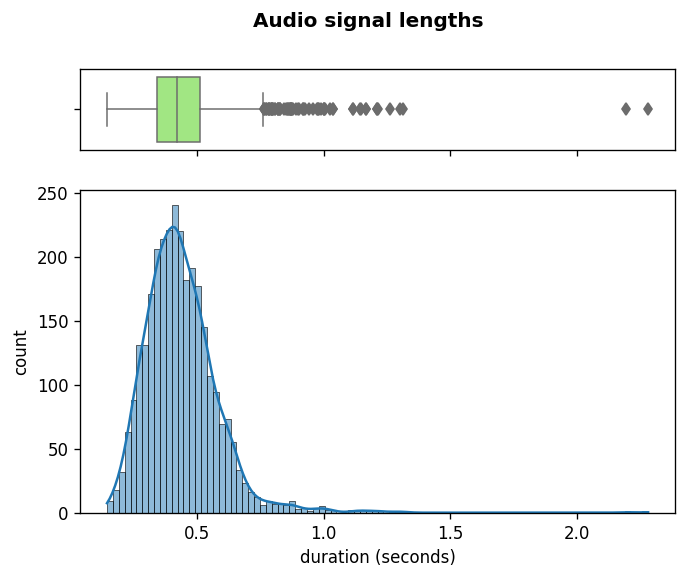

In [74]:
lengths = audio.show_length_distribution(X)

Casos extermos:

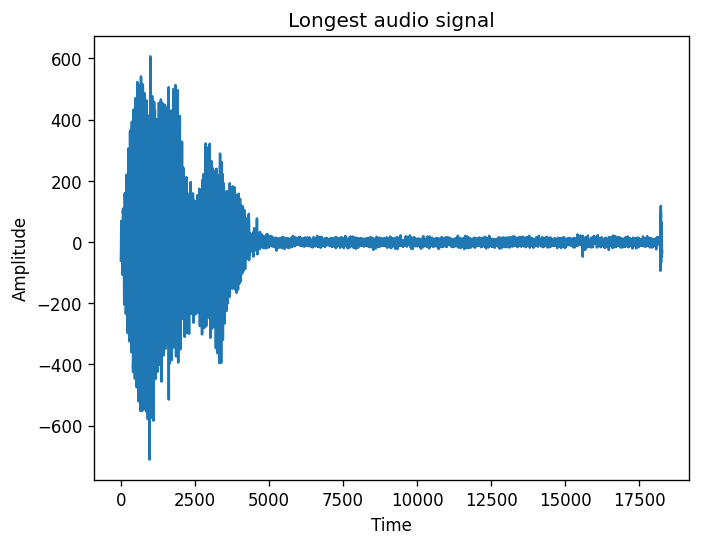

In [75]:
longest_audio = np.argmax([len(x) for x in X])
plt.plot(X[longest_audio])
plt.title("Longest audio signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

display(ipd.Audio(X[longest_audio], rate=audio.sample_rate))

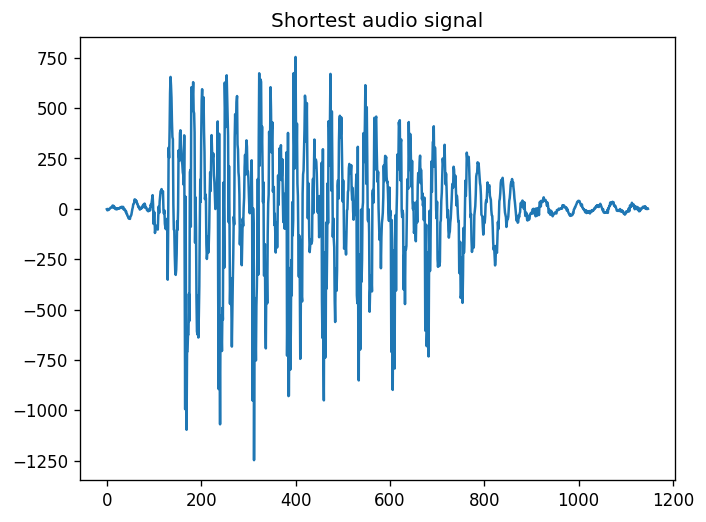

In [76]:
shortest_audio = np.argmin([len(x) for x in X])
plt.plot(X[shortest_audio])
plt.title("Shortest audio signal")
plt.show()

display(ipd.Audio(X[shortest_audio], rate= audio.sample_rate))

## Remoção de recursos do domínio do tempo:
Vamos remover o silêncio inicial e final dos sinais para ver se obtemos uma distribuição diferente de comprimento. 

In [77]:
max_size = 0
for x in X:
    max_size = max(max_size, x.shape[0])
    
print('Max sizing before:', max_size)

# trim silence
X = [audio.remove_silence(x) for x in X ]


max_size = 0
for x in X:
    max_size = max(max_size, x.shape[0])
    
print('Max sizing after:', max_size)

INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioPr

Max sizing before: 18262


INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioPr

Max sizing after: 6457


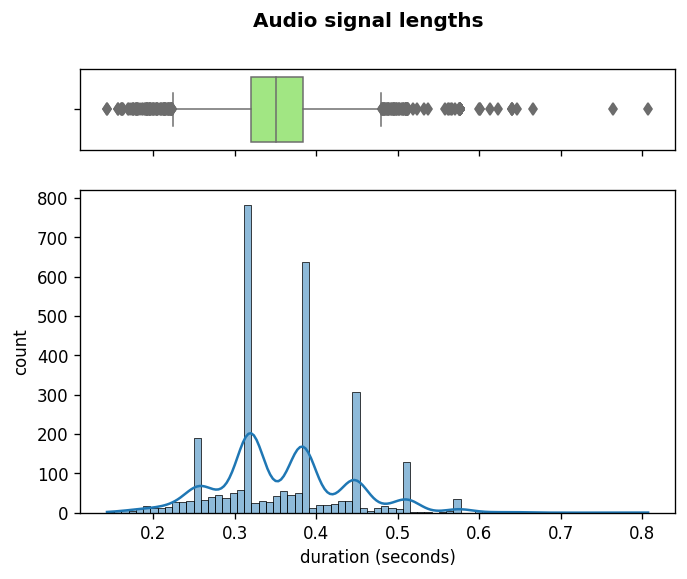

In [78]:
lengths = audio.show_length_distribution(X)

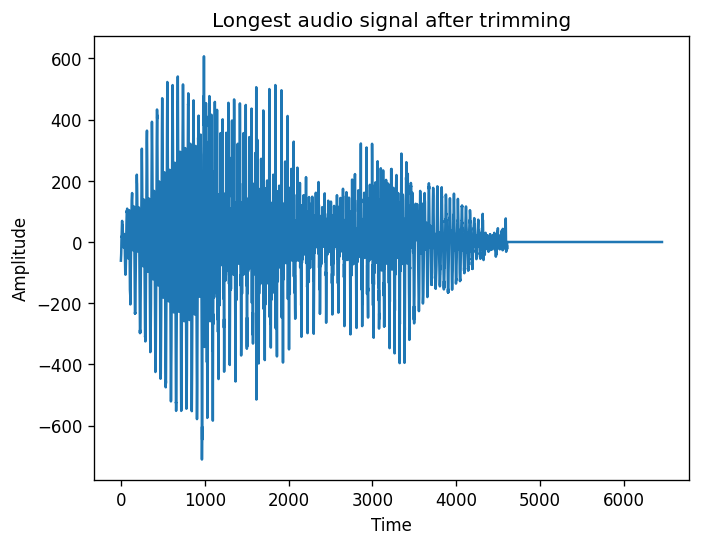

In [79]:
# add padding to max size
#! ATENÇÃO NÃO É O MESMO PADDING DO AUDIOPROCESSOR
X = [ np.pad(x, (0, max_size - x.shape[0])) for x in X ] 

plt.plot(X[longest_audio])
plt.title("Longest audio signal after trimming")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

display(ipd.Audio(X[longest_audio], rate=audio.sample_rate))

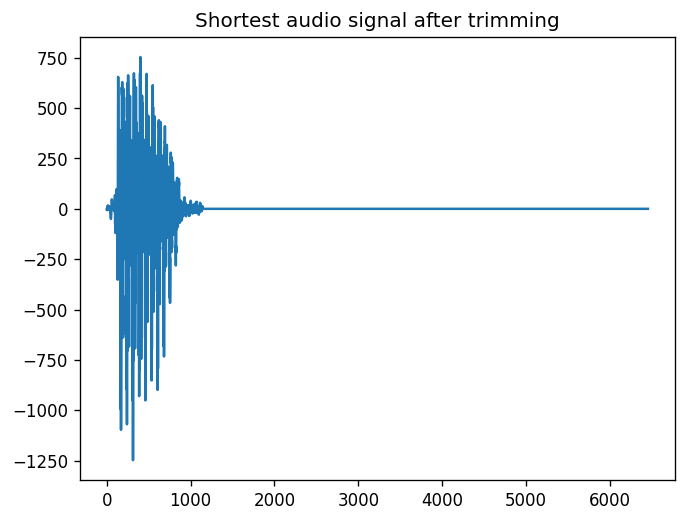

In [80]:
plt.plot(X[shortest_audio])
plt.title("Shortest audio signal after trimming")
plt.show()

display(ipd.Audio(X[shortest_audio], rate=audio.sample_rate))

# Spectorgrams

In [81]:
import librosa
import tensorflow as tf
import tensorflow_io as tfio

def freq_mask(spec):
    return tfio.audio.freq_mask(spec, param=2).numpy()

def time_mask(spec):
    return tfio.audio.time_mask(spec, param=2).numpy()


def mel_spectrogram(waveform):
    spec = librosa.feature.melspectrogram(y=waveform, sr=8000)
    return librosa.power_to_db(spec, ref=np.max)


def mfcc_spectrogram(waveform):
    return librosa.feature.mfcc(y=waveform, sr=8000)


def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)



def stft_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([max_size] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram



(128, 13)
(20, 13)


[Text(0.5, 1.0, 'MFCC Spectrogram with Freq. and Time Mask')]

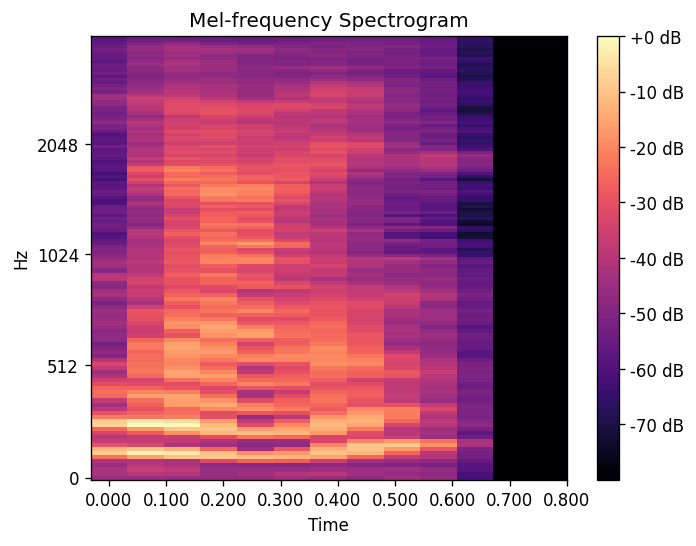

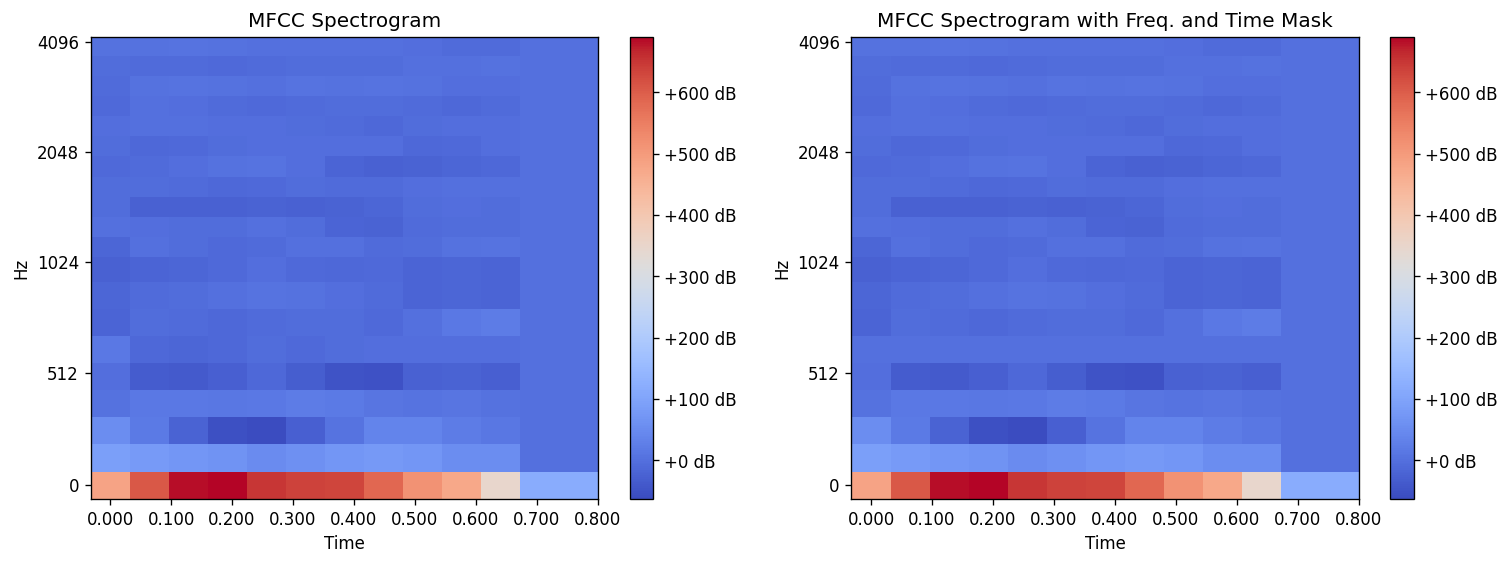

In [82]:
wave = X[longest_audio]

S = mel_spectrogram(wave)
print(S.shape)

fig, ax = plt.subplots()

img = librosa.display.specshow(S, x_axis='time',
                         y_axis='mel', sr=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency Spectrogram')



S = mfcc_spectrogram(wave)
print(S.shape)


fig, ax = plt.subplots(1,2)

img = librosa.display.specshow(S, x_axis='time',
                         y_axis='mel', sr=8000, ax=ax[0])
fig.colorbar(img, ax=ax[0], format='%+2.0f dB')
ax[0].set(title='MFCC Spectrogram')


S2 = freq_mask(time_mask(S))

#fig, ax = plt.subplots()

img = librosa.display.specshow(S2, x_axis='time',
                         y_axis='mel', sr=8000, ax=ax[1])

fig.colorbar(img, ax=ax[1], format='%+2.0f dB')
fig.set_size_inches(15, 5)
ax[1].set(title='MFCC Spectrogram with Freq. and Time Mask')



(49, 129)


/tmp/ipykernel_157107/1214233773.py:24: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


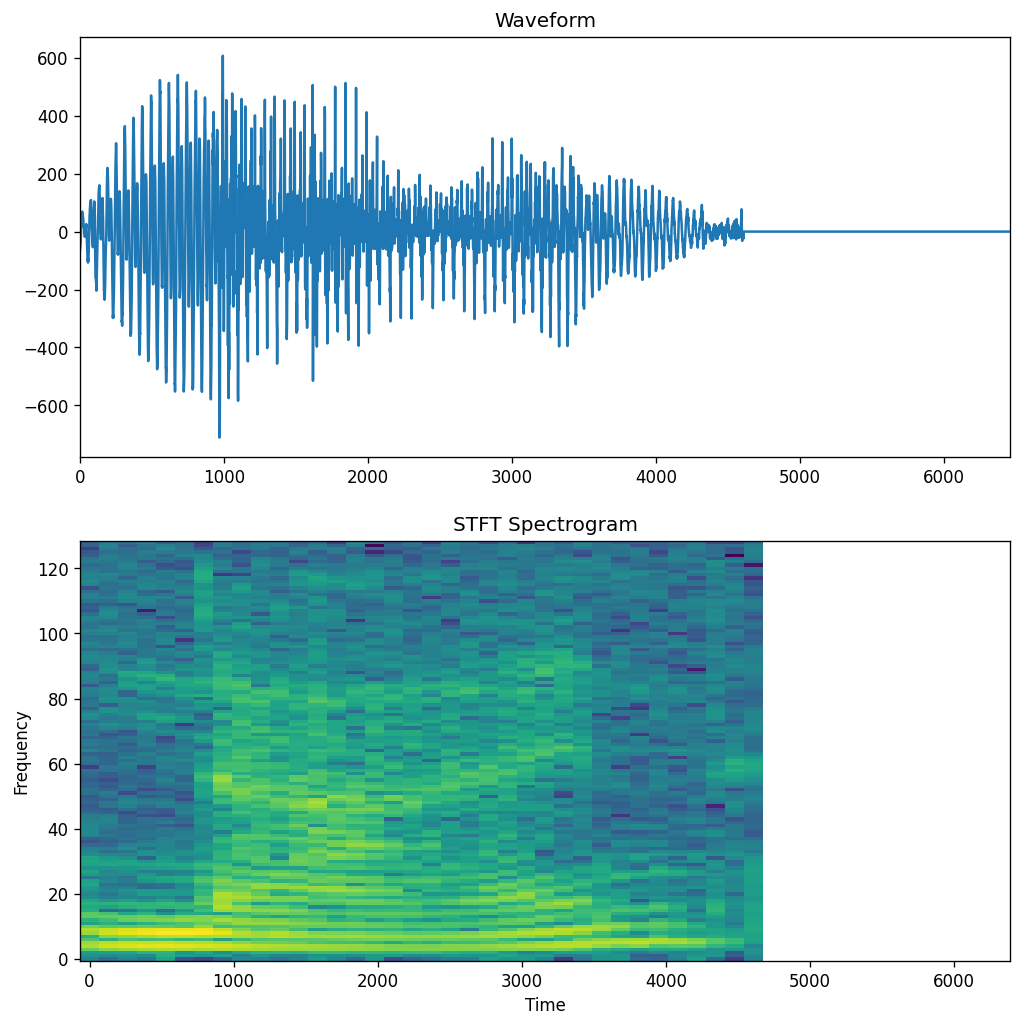

In [83]:
waveform = X[longest_audio]

spectrogram = stft_spectrogram(waveform).numpy()

#spectrogram.resize(32, 32)
print(spectrogram.shape)

timescale = np.arange(waveform.shape[0])
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, max_size])

fig.set_size_inches(10, 10)

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Frequency')
axes[1].set_title('STFT Spectrogram')

plot_spectrogram(spectrogram, axes[1])

# Data Split (MFCC)

In [84]:
import os
from src.models import model_1,model_2,model_3,model_4,model_5,model_6

def load_data(spectogram_type):
    train_X = np.array([np.load(f"data/spectograms/{spectogram_type}/train/{file}") for file in os.listdir(f"data/spectograms/{spectogram_type}/train")])
    train_Y = np.array([int(file.split("_")[1]) for file in os.listdir(f"data/spectograms/{spectogram_type}/train")])
    cv_X = np.array([np.load(f"data/spectograms/{spectogram_type}/cv/{file}") for file in os.listdir(f"data/spectograms/{spectogram_type}/cv")])
    cv_Y = np.array([int(file.split("_")[1]) for file in os.listdir(f"data/spectograms/{spectogram_type}/cv")])
    test_X = np.array([np.load(f"data/spectograms/{spectogram_type}/test/{file}") for file in os.listdir(f"data/spectograms/{spectogram_type}/test")])
    test_Y = np.array([int(file.split("_")[1]) for file in os.listdir(f"data/spectograms/{spectogram_type}/test")])

    return train_X, train_Y, cv_X, cv_Y, test_X, test_Y



train_X, train_Y, cv_X, cv_Y, test_X, test_Y = load_data("mfcc")

print(len(train_X), len(cv_X), len(test_X))

900 900 1200


In [85]:
from sklearn.metrics import confusion_matrix


def train_model(model, train_X, train_Y, cv_X, cv_Y):
    return model.fit(train_X, train_Y, epochs=25, validation_data=(cv_X, cv_Y))

def plot_accuracy_loss(history):
    metrics = history.history
    fig, ax = plt.subplots(1, 2)

    ax[0].plot(history.epoch, metrics['loss'], metrics['val_loss'])
    ax[0].set_xlabel('Epochs')
    ax[0].legend(['train loss', 'validation loss'])


    ax[1].plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylim([0, 1])
    ax[1].legend(['train accuracy', 'validation accuracy'])

    fig.set_size_inches(8, 5)
    plt.show()


def plot_confusion_matrix(true_categories, predicted_categories):
    cm = confusion_matrix(true_categories, predicted_categories)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d',cmap='crest')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def run_model(model, train_X, train_Y, cv_X, cv_Y, test_X, test_Y, plot=False, save=False, model_name="model_1"):
    history = train_model(model, train_X, train_Y, cv_X, cv_Y)

    test_loss, test_acc = model.evaluate(test_X, test_Y, verbose=2)

    print(f"Test accuracy: {test_acc}")

    print(model.summary())

    if plot:
        plot_accuracy_loss(history)
        # Predict the test data
        y_pred = model.predict(test_X)
        predicted_categories = np.argmax(y_pred, axis=1)
        true_categories = test_Y
        plot_confusion_matrix(true_categories, predicted_categories)

    return test_loss, test_acc


# Model 1

Running model
(900, 20, 13)
Epoch 1/25


/home/mariana/Desktop/lei-taa-2/venv/lib/python3.9/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


29/29 [==============================] - 3s 59ms/step - loss: 1.2760 - accuracy: 0.5944 - val_loss: 1.7625 - val_accuracy: 0.3611
Epoch 2/25
29/29 [==============================] - 1s 30ms/step - loss: 0.5303 - accuracy: 0.8256 - val_loss: 1.7306 - val_accuracy: 0.4722
Epoch 3/25
29/29 [==============================] - 1s 33ms/step - loss: 0.3531 - accuracy: 0.8800 - val_loss: 1.4833 - val_accuracy: 0.5700
Epoch 4/25
29/29 [==============================] - 1s 31ms/step - loss: 0.2833 - accuracy: 0.9144 - val_loss: 1.3302 - val_accuracy: 0.5800
Epoch 5/25
29/29 [==============================] - 1s 36ms/step - loss: 0.2027 - accuracy: 0.9367 - val_loss: 0.4652 - val_accuracy: 0.8611
Epoch 6/25
29/29 [==============================] - 1s 32ms/step - loss: 0.1623 - accuracy: 0.9389 - val_loss: 0.7051 - val_accuracy: 0.7622
Epoch 7/25
29/29 [==============================] - 1s 38ms/step - loss: 0.0749 - accuracy: 0.9833 - val_loss: 0.3543 - val_accuracy: 0.8911
Epoch 8/25
29/29 [======

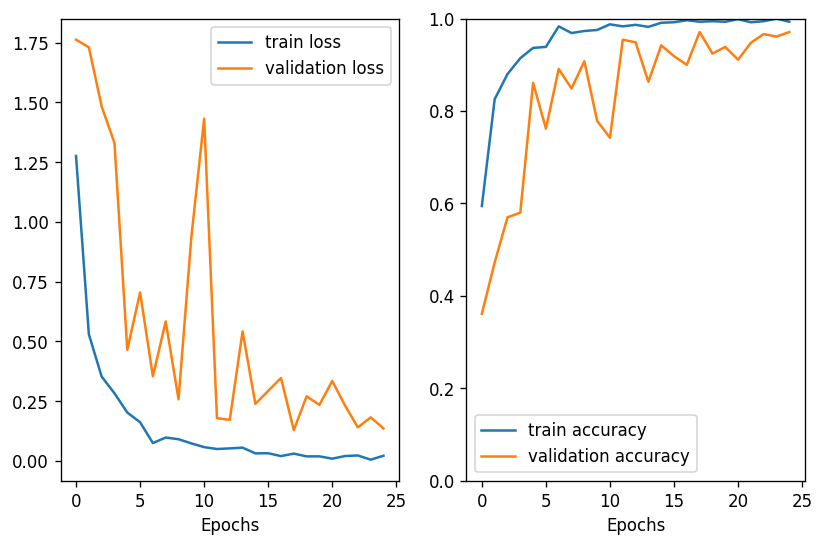

38/38 [==============================] - 1s 9ms/step


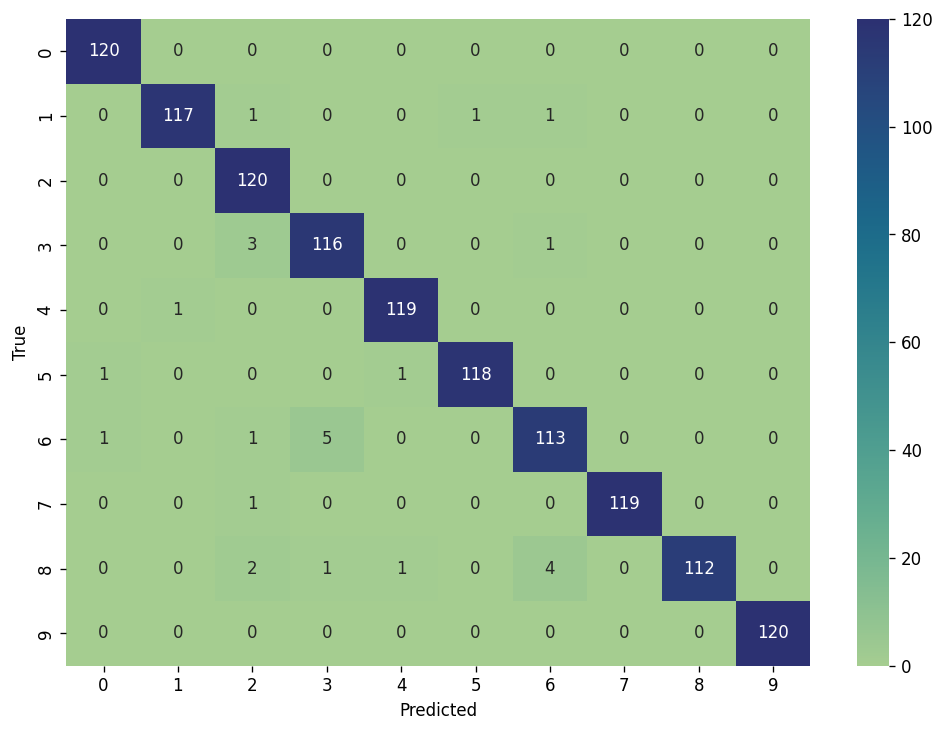

loss: 0.09819933772087097, accuracy: 0.9783333539962769


In [86]:
print("Running model")
print(train_X.shape)
loss, accuracy = run_model(model_1(train_X), train_X, train_Y, cv_X, cv_Y, test_X, test_Y, plot=True)
print(f"loss: {loss}, accuracy: {accuracy}")

# Model 2

Running model
(900, 20, 13)
Epoch 1/25


/home/mariana/Desktop/lei-taa-2/venv/lib/python3.9/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


29/29 [==============================] - 2s 38ms/step - loss: 1.5185 - accuracy: 0.5156 - val_loss: 3.5169 - val_accuracy: 0.1567
Epoch 2/25
29/29 [==============================] - 1s 30ms/step - loss: 0.5923 - accuracy: 0.8000 - val_loss: 1.6166 - val_accuracy: 0.3833
Epoch 3/25
29/29 [==============================] - 1s 49ms/step - loss: 0.3771 - accuracy: 0.8789 - val_loss: 0.9688 - val_accuracy: 0.7256
Epoch 4/25
29/29 [==============================] - 1s 31ms/step - loss: 0.2507 - accuracy: 0.9211 - val_loss: 0.7136 - val_accuracy: 0.7733
Epoch 5/25
29/29 [==============================] - 1s 35ms/step - loss: 0.1753 - accuracy: 0.9522 - val_loss: 0.5331 - val_accuracy: 0.8333
Epoch 6/25
29/29 [==============================] - 1s 30ms/step - loss: 0.1410 - accuracy: 0.9622 - val_loss: 0.3448 - val_accuracy: 0.9056
Epoch 7/25
29/29 [==============================] - 1s 32ms/step - loss: 0.1285 - accuracy: 0.9644 - val_loss: 0.2211 - val_accuracy: 0.9367
Epoch 8/25
29/29 [======

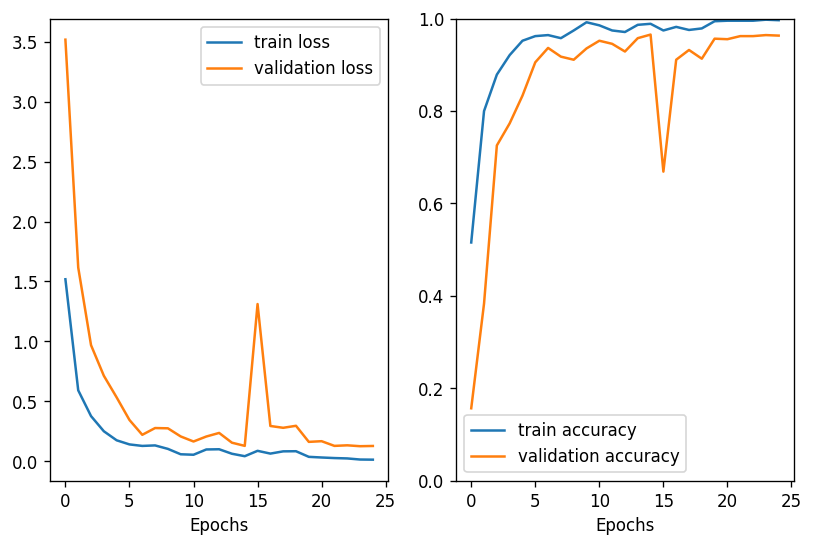

38/38 [==============================] - 1s 8ms/step


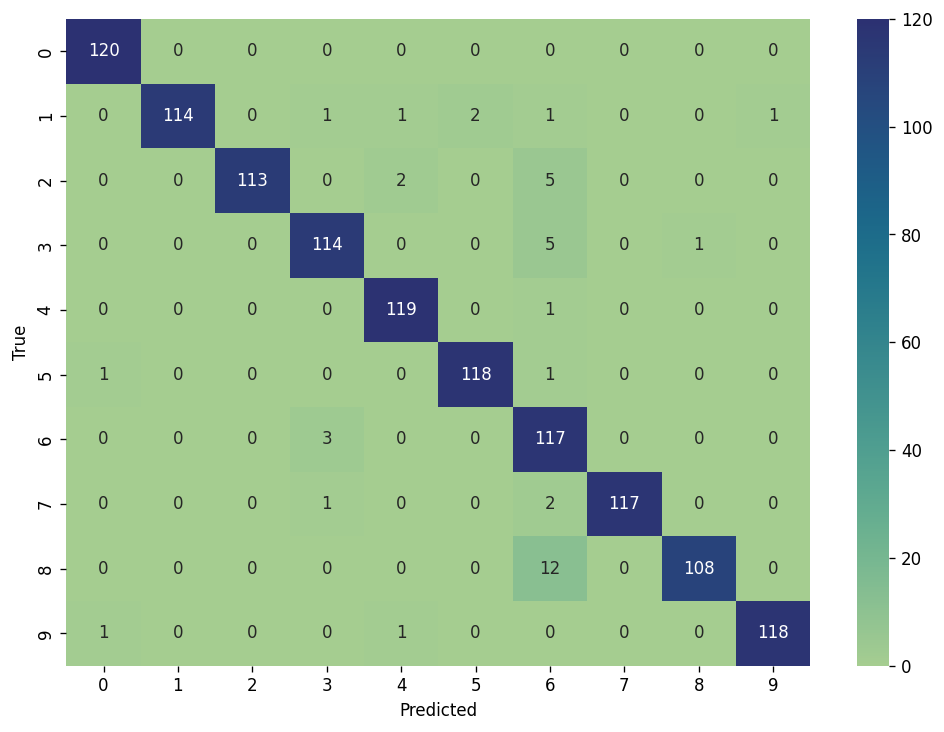

loss: 0.11436847597360611, accuracy: 0.9649999737739563


In [87]:
print("Running model")
print(train_X.shape)
loss, accuracy = run_model(model_2(train_X), train_X, train_Y, cv_X, cv_Y, test_X, test_Y, plot=True)
print(f"loss: {loss}, accuracy: {accuracy}")

# Model 3

Running model
(900, 20, 13)
Epoch 1/25
29/29 [==============================] - 2s 63ms/step - loss: 6.5488 - accuracy: 0.3578 - val_loss: 1.3194 - val_accuracy: 0.5144
Epoch 2/25
29/29 [==============================] - 2s 56ms/step - loss: 0.7946 - accuracy: 0.7222 - val_loss: 0.5104 - val_accuracy: 0.7989
Epoch 3/25
29/29 [==============================] - 2s 57ms/step - loss: 0.4202 - accuracy: 0.8533 - val_loss: 0.3349 - val_accuracy: 0.8922
Epoch 4/25
29/29 [==============================] - 1s 50ms/step - loss: 0.3595 - accuracy: 0.8856 - val_loss: 0.9164 - val_accuracy: 0.6867
Epoch 5/25
29/29 [==============================] - 2s 54ms/step - loss: 0.2530 - accuracy: 0.9189 - val_loss: 0.3424 - val_accuracy: 0.8911
Epoch 6/25
29/29 [==============================] - 1s 52ms/step - loss: 0.1978 - accuracy: 0.9367 - val_loss: 0.3560 - val_accuracy: 0.9022
Epoch 7/25
29/29 [==============================] - 2s 61ms/step - loss: 0.1784 - accuracy: 0.9444 - val_loss: 0.6434 - val_ac

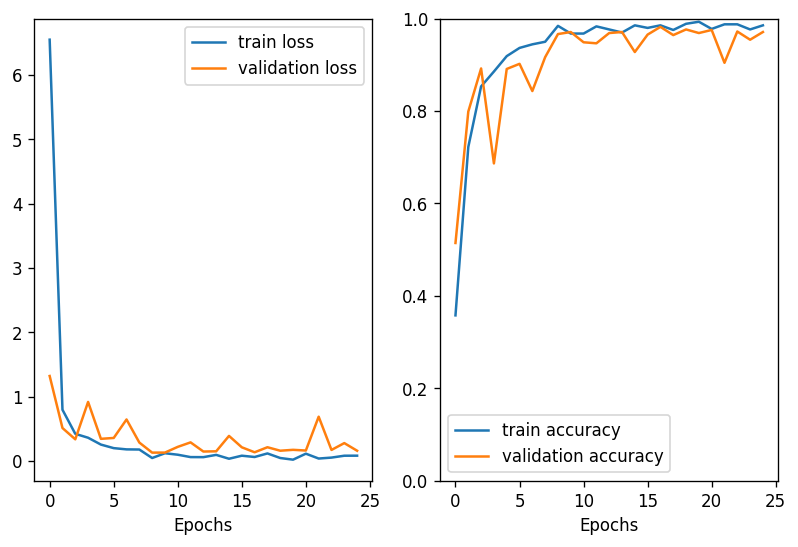

38/38 [==============================] - 1s 12ms/step


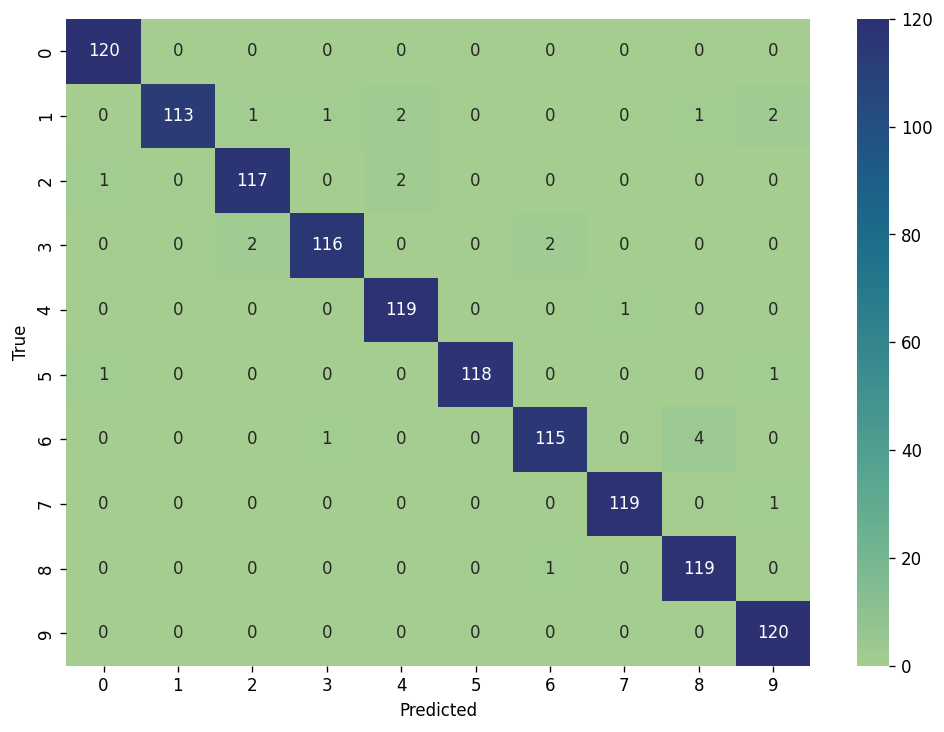

loss: 0.09990835934877396, accuracy: 0.9800000190734863


In [88]:
print("Running model")
print(train_X.shape)
loss, accuracy = run_model(model_3(train_X), train_X, train_Y, cv_X, cv_Y, test_X, test_Y, plot=True)
print(f"loss: {loss}, accuracy: {accuracy}")

# Model 4

Running model
(900, 20, 13)
Epoch 1/25
29/29 [==============================] - 2s 53ms/step - loss: 4.5024 - accuracy: 0.2833 - val_loss: 1.2530 - val_accuracy: 0.6200
Epoch 2/25
29/29 [==============================] - 1s 51ms/step - loss: 0.9862 - accuracy: 0.6511 - val_loss: 0.4971 - val_accuracy: 0.8322
Epoch 3/25
29/29 [==============================] - 1s 46ms/step - loss: 0.4156 - accuracy: 0.8511 - val_loss: 0.2963 - val_accuracy: 0.8944
Epoch 4/25
29/29 [==============================] - 1s 51ms/step - loss: 0.2429 - accuracy: 0.9178 - val_loss: 0.1578 - val_accuracy: 0.9544
Epoch 5/25
29/29 [==============================] - 2s 54ms/step - loss: 0.1732 - accuracy: 0.9322 - val_loss: 0.1414 - val_accuracy: 0.9578
Epoch 6/25
29/29 [==============================] - 1s 50ms/step - loss: 0.1032 - accuracy: 0.9689 - val_loss: 0.1292 - val_accuracy: 0.9678
Epoch 7/25
29/29 [==============================] - 1s 52ms/step - loss: 0.1090 - accuracy: 0.9644 - val_loss: 0.1330 - val_ac

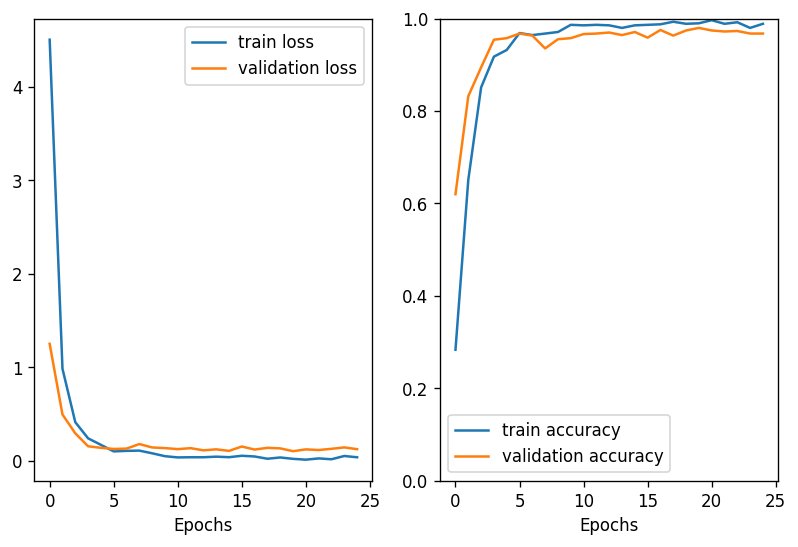

38/38 [==============================] - 1s 15ms/step


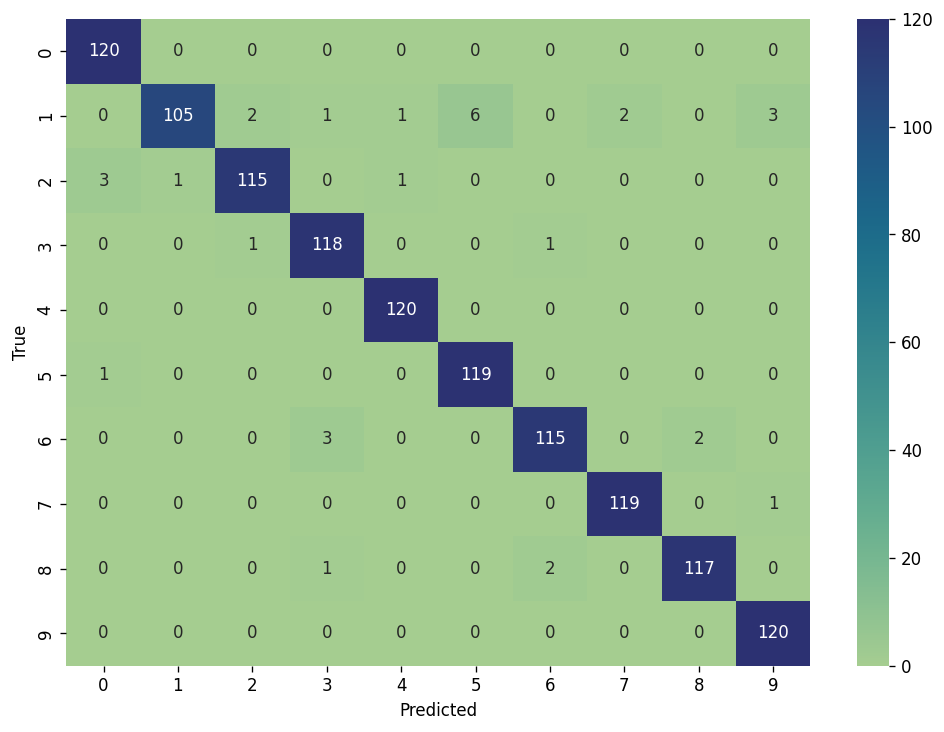

loss: 0.10852506011724472, accuracy: 0.9733333587646484


In [89]:
print("Running model")
print(train_X.shape)
loss, accuracy = run_model(model_4(train_X), train_X, train_Y, cv_X, cv_Y, test_X, test_Y, plot=True)
print(f"loss: {loss}, accuracy: {accuracy}")

# Model 5

Running model
(900, 20, 13)
Epoch 1/25
29/29 [==============================] - 1s 31ms/step - loss: 5.3411 - accuracy: 0.2533 - val_loss: 1.2821 - val_accuracy: 0.6389
Epoch 2/25
29/29 [==============================] - 1s 28ms/step - loss: 1.0287 - accuracy: 0.6189 - val_loss: 0.5860 - val_accuracy: 0.8189
Epoch 3/25
29/29 [==============================] - 1s 22ms/step - loss: 0.5865 - accuracy: 0.7800 - val_loss: 0.3297 - val_accuracy: 0.8944
Epoch 4/25
29/29 [==============================] - 1s 31ms/step - loss: 0.4096 - accuracy: 0.8667 - val_loss: 0.2489 - val_accuracy: 0.9167
Epoch 5/25
29/29 [==============================] - 1s 38ms/step - loss: 0.2518 - accuracy: 0.9044 - val_loss: 0.1917 - val_accuracy: 0.9389
Epoch 6/25
29/29 [==============================] - 1s 23ms/step - loss: 0.1912 - accuracy: 0.9300 - val_loss: 0.1433 - val_accuracy: 0.9511
Epoch 7/25
29/29 [==============================] - 1s 34ms/step - loss: 0.1440 - accuracy: 0.9500 - val_loss: 0.1752 - val_ac

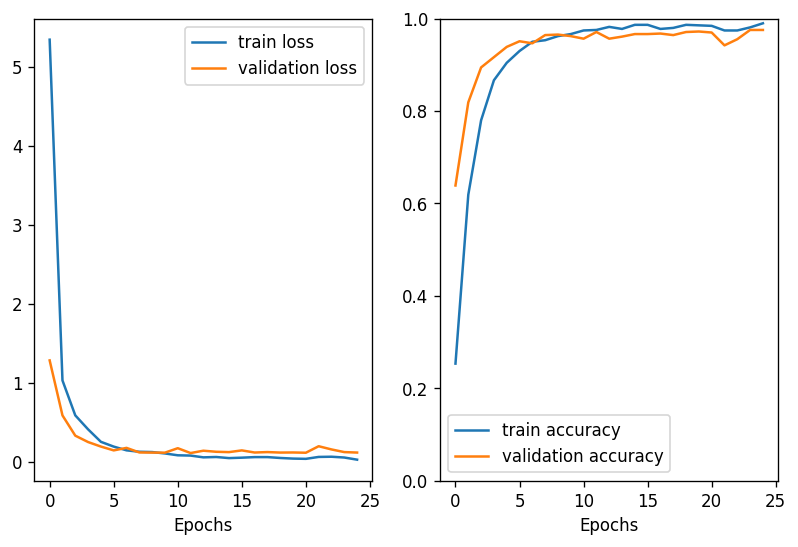

38/38 [==============================] - 0s 11ms/step


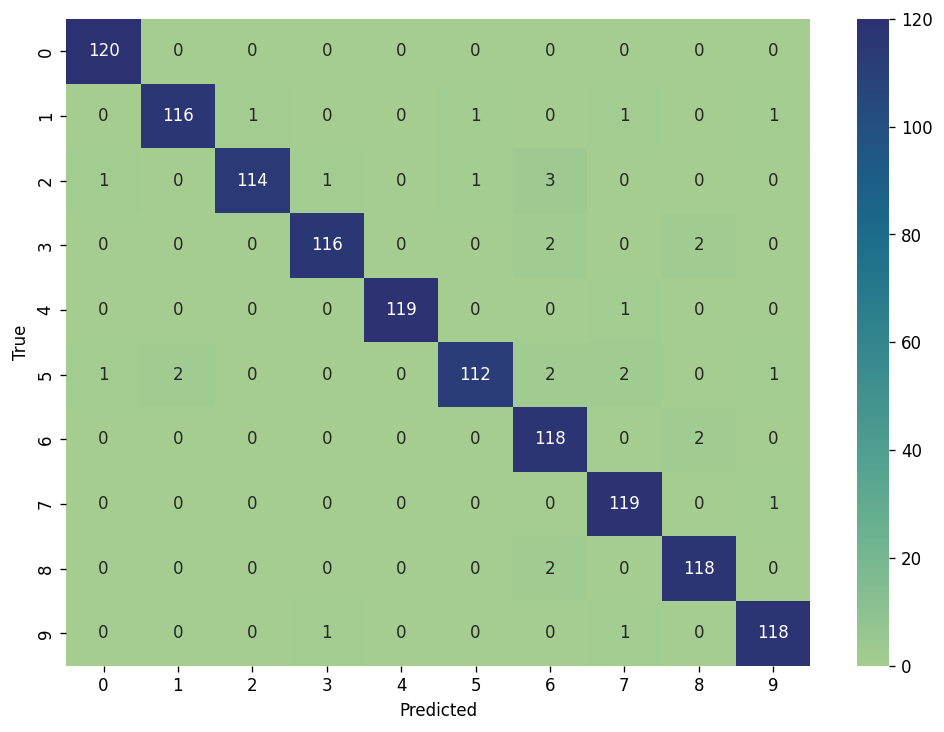

loss: 0.08862686157226562, accuracy: 0.9750000238418579


In [90]:
print("Running model")
print(train_X.shape)
loss, accuracy = run_model(model_5(train_X), train_X, train_Y, cv_X, cv_Y, test_X, test_Y, plot=True)
print(f"loss: {loss}, accuracy: {accuracy}")

# Model 6

Running model
(900, 20, 13)
Epoch 1/25
29/29 [==============================] - 1s 33ms/step - loss: 19.3033 - accuracy: 0.1989 - val_loss: 1.8913 - val_accuracy: 0.3356
Epoch 2/25
29/29 [==============================] - 1s 29ms/step - loss: 2.4280 - accuracy: 0.2856 - val_loss: 1.9913 - val_accuracy: 0.2967
Epoch 3/25
29/29 [==============================] - 1s 31ms/step - loss: 1.9169 - accuracy: 0.2911 - val_loss: 1.7031 - val_accuracy: 0.3978
Epoch 4/25
29/29 [==============================] - 1s 37ms/step - loss: 1.6791 - accuracy: 0.3822 - val_loss: 1.3474 - val_accuracy: 0.5633
Epoch 5/25
29/29 [==============================] - 1s 32ms/step - loss: 1.4624 - accuracy: 0.4933 - val_loss: 1.0654 - val_accuracy: 0.6389
Epoch 6/25
29/29 [==============================] - 1s 38ms/step - loss: 1.1657 - accuracy: 0.6178 - val_loss: 0.7928 - val_accuracy: 0.7489
Epoch 7/25
29/29 [==============================] - 1s 34ms/step - loss: 0.9677 - accuracy: 0.6922 - val_loss: 0.7759 - val_a

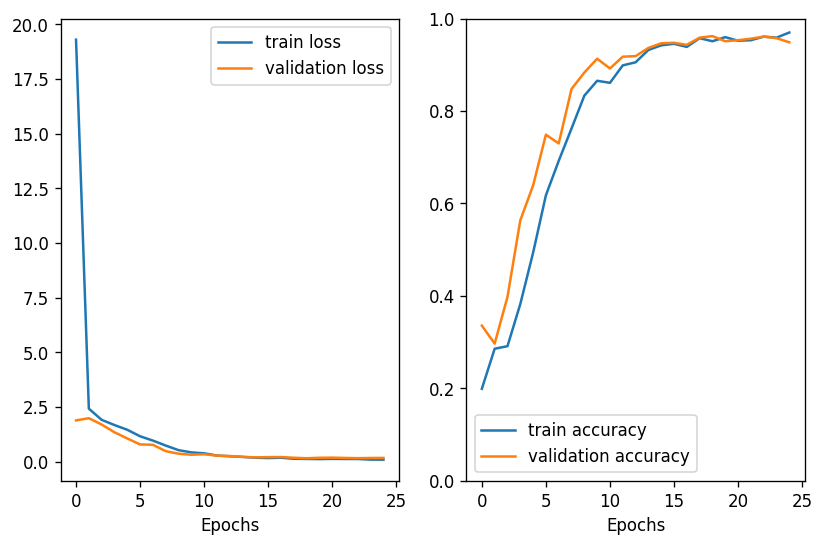

38/38 [==============================] - 0s 9ms/step


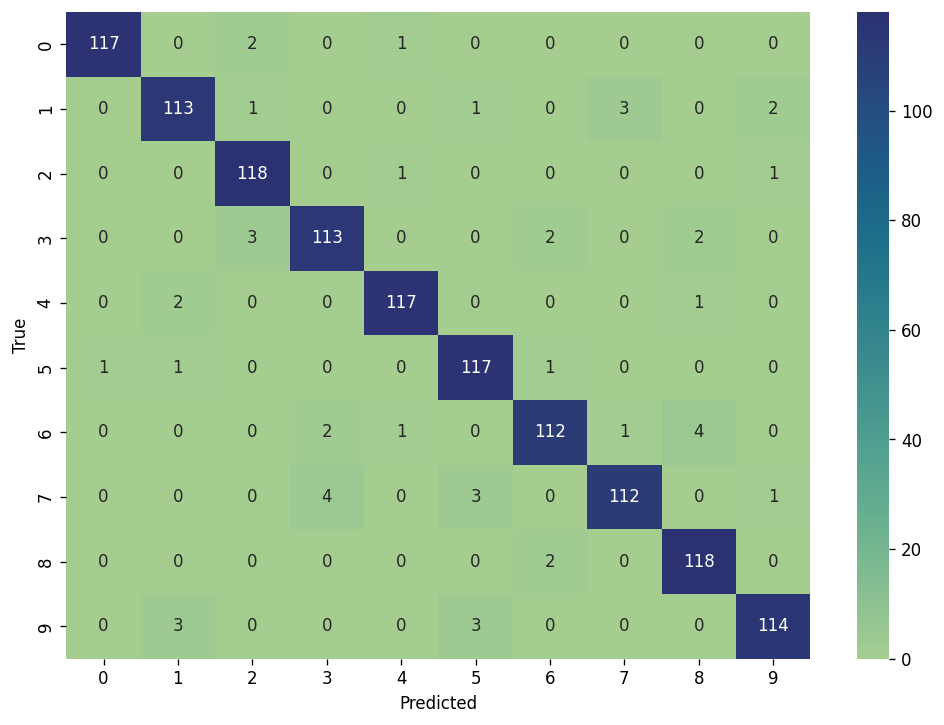

loss: 0.1488107591867447, accuracy: 0.9591666460037231


In [91]:
print("Running model")
print(train_X.shape)
loss, accuracy = run_model(model_6(train_X), train_X, train_Y, cv_X, cv_Y, test_X, test_Y, plot=True)
print(f"loss: {loss}, accuracy: {accuracy}")